# 4X Study Dashboard
This notebook is used to analyze data from the 4X study conducted in March 2018.

# Imports and Global Setup

In [645]:
# data processing
import math
import json
from multiprocessing import Pool, cpu_count
from multiprocessing.dummy import Pool as ThreadPool 
from functools import reduce
from collections import Counter

import requests
import pandas as pd
import numpy as np
from scipy import stats

from datetime import datetime, timezone
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm

In [646]:
# google
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from operator import itemgetter

In [647]:
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [813]:
# palette
sns.set(font_scale=1.5, style='whitegrid')
# sns.set_palette("cubehelix")
sns.set_palette(sns.cubehelix_palette(rot=-.4))

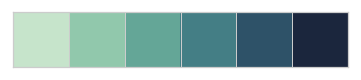

In [819]:
sns.palplot(sns.color_palette())

## Setup Google Sheets Auth

In [649]:
# setup connection
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('credential.json', scope)
gc = gspread.authorize(credentials)

In [650]:
def load_google_sheet_data(url, new_col_names=[]):
    """
    Loads in and returns post-study as a Pandas DataFrame with header remapped according to values above.
    
    Inputs:
        url (string): url of spreadsheet to load in
        new_col_names (list): list of strings for new column names
    
    Returns:
        (DataFrame): Pandas DataFrame with header remapped above
    """
    url_connection = gc.open_by_url(url)
    raw_data = url_connection.get_worksheet(0).get_all_values()
    
    output_df = pd.DataFrame(raw_data[1:], columns=raw_data[0])
    if len(new_col_names) > 0:
        output_df.columns = new_col_names

    return output_df

# Load in data

## Log Data from LES

In [651]:
# URL for hosted Parse server
url = 'https://les-expand.herokuapp.com/parse/classes/'

# shared header and data for Parse
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '20000'}

# study start and end
start_time = '2018-08-27 05:00:00'
mid_time = '2018-09-02 05:00:00'
end_time = '2018-09-10 05:00:00'

start_time_date = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
mid_time_date = datetime.strptime(mid_time, '%Y-%m-%d %H:%M:%S')
end_time_date = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')

print('Study Length: {}'.format(end_time_date - start_time_date))

Study Length: 14 days, 0:00:00


In [652]:
def load_data(base_url, header, data, start_time, end_time):
    """
    Loads in all needed tables from database, given url.
    
    Input: 
        base_url (string): url to pull data from
        header (dict): application id and other auth
        data (dict): data to pass into query
        start_time (datetime): start time for data
        end_time (datetime): end time for data 
    
    Return:
        (dict): dict where keys are collection names and values are Pandas objects containing data
    """
    # declare collection list
    collection_list = ['_User', 'ServerLog', 'DebugLog', 'ForYouViewLog', 'ApplicationHeartbeat',
                       'TaskLocations', 'LocationTypeMetadata', 'beacons', 'EnRouteLocations',
                       'AtLocationNotificationsSent', 'AtLocationNotificationResponses',
                       'EnRouteNotificationsSent', 'EnRouteNotificationResponses',
                       'AtDistanceNotificationsSent', 'AtDistanceNotificationResponses']
    
    # loop through and load data for each collection
    output = {}
    for collection in tqdm(collection_list):
        current_response = requests.get(base_url + collection, headers=header, data=data)

        current_data = pd.DataFrame(current_response.json()['results'])
        if len(current_data) != 0 and collection not in ['LocationTypeMetadata', 'EnRouteLocations']:
            current_data['createdAt'] = pd.to_datetime(current_data['createdAt'])
            current_data['updatedAt'] = pd.to_datetime(current_data['updatedAt'])
            
            if collection != '_User':
                current_data = current_data[(current_data['createdAt'] >= start_time) & (current_data['createdAt'] < end_time)]

        output[collection] = current_data
    
    return output

def load_data_parallel(url):
    return load_data(url, header, data, start_time, end_time)

In [653]:
# fetch log data
raw_data = load_data(url, header, data, start_time, end_time)

## Post-Study Survey Data TODO

In [654]:
replacement_dict = {
    '1: Very invaluable': 1,
    '2: Invaluable': 2,
    '3: Neutral': 3,
    '4: Valuable': 4,
    '5: Very valuable': 5,
    '1: Never': 1,
    '2: Rarely, in less than 10% of the notifications': 2,
    '3: Occasionally, in about 30% of the notifications': 3,
    '4: Sometimes, in about 50% of the notifications': 4,
    '5: Frequently, in about 70% of the notifications': 5,
    '6: Usually, in about 90% of the notifications': 6,
    '7: Every time I was notified': 7,
    '1: Not likely': 1,
    '2: Somewhat unlikely': 2,
    '3: Neutral': 3,
    '4: Somewhat likely': 4,
    '5: Very likely': 5,
    '1: Not disruptive, easy to do and continue on with my routine': 1,
    '2: Rarely disruptive': 2,
    '3: Occasionally disruptive': 3,
    '4: Moderately disruptive': 4,
    '5: A great deal disruptive, I had to stop what I was doing to answer': 5,
    '0: N/A': 0,
    '1: Far fewer than I would have liked': 1,
    '2: Fewer than I would have liked': 2,
    '3: About correct for the number I would have liked': 3,
    '4: More than I would have liked': 4,
    '5: Far more than I would have liked': 5,
    '': -1
}

In [655]:
# setup 4X post-survey data
url_4x = 'https://docs.google.com/spreadsheets/d/1rCH32DdAfnOSoe-qNIQgO7rQei2VATHxLlGfP0bCNg8/edit#gid=339656711'
cols_4x = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'expand_info_going',
    'expand_info_going_notgo',
    'expand_info_notuseful',
    'expand_info_altprefs',
    'expand_info_disruption',
    'expand_info_number_notif',
    'exploit_atloc',
    'exploit_enroute',
    'exploit_disruption',
    'miscellaneous'
]
post_study_4x = load_google_sheet_data(url_4x, new_col_names=cols_4x)
post_study_4x.replace(to_replace=replacement_dict, inplace=True)
post_study_4x['overall_disruption'] = (2/3) * post_study_4x['overall_disruption'] + (1/3)

# remove bad users
post_study_4x = post_study_4x[post_study_4x['email_address'] != 'jamiekuhn2019@u.northwestern.edu']

post_study_4x.to_csv('./analysis/post_study_4x.csv', index=False)
post_study_4x.head(1)

,timestamp,email_address,name,overall_value,overall_disruption,future_use,overall_experience,explore_respond,explore_not_respond,explore_disruption,expand_info_going,expand_info_going_notgo,expand_info_notuseful,expand_info_altprefs,expand_info_disruption,expand_info_number_notif,exploit_atloc,exploit_enroute,exploit_disruption,miscellaneous
0,3/18/2018 23:17:30,allisonsun2018@u.northwestern.edu,Allison Sun,3,1.666667,4,I liked being notified for free food in Ford a...,Always responded to the notifications for Ford...,Can't think of any instances when I didn't res...,2,Only went the free food places in ford because...,N/A,N/A,Coffee shops that I frequent more like Peets a...,2,2,N/A,N/A,0,-1


# Data Setup
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper

## Common Functions and Data

In [656]:
def get_merged_at_location(tasklocations, atlocnotif, atlocresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtLocation case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atlocnotif (DataFrame): DataFrame of AtLocationNotificationsSent
        atlocresp (DataFrame): DataFrame of AtLocationNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtLocationNotifications without duplicates
    atlocnotif.sort_values('createdAt', inplace=True)
    atlocnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtLocationNotificationResponses without duplicates
    atlocresp.sort_values('createdAt', inplace=True)
    atlocresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtLocation notifications and responses, with some data from TaskLocations
    atloc = atlocnotif.merge(tasklocations[['objectId', 'locationType', 'locationName', 'beaconId']],
                             how='inner', left_on='taskLocationId', right_on='objectId')
    atloc = atloc.merge(atlocresp[['question', 'response', 'timestamp', 'taskLocationId', 'vendorId']],
                        how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atloc['objectId']
    atloc.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'},
                 inplace=True)
    
    # fill blank columns
    atloc[['question', 'response']] = atloc[['question', 'response']].fillna(value='Missed Notification')
    atloc[['distanceToLocation', 'responseTimestamp']] = atloc[['distanceToLocation', 'responseTimestamp']].fillna(value=-1)

    # type columns
    atloc_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atloc[atloc_int_cols] = atloc[atloc_int_cols].apply(lambda x: x.astype(np.int64))
    
    # add remappedResponses column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    atloc['remappedResponses'] = atloc['response']
    atloc.loc[~atloc['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    atloc.loc[atloc['remappedResponses'] == 'com.apple.UNNotificationDismissActionIdentifier', 'remappedResponses'] = 'Dismissed Notification'
    atloc.loc[atloc['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'
    
    # reorder columns
    atloc_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation',
                          'locationType', 'locationName','gmtOffset', 'notificationTimestamp', 'notificationString',
                          'question', 'response', 'remappedResponses', 'responseTimestamp']
    atloc = atloc[atloc_col_ordering]
    
    return atloc

In [657]:
def get_merged_at_distance(tasklocations, atdistnotif, atdistresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtDistance case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atdistnotif (DataFrame): DataFrame of AtDistanceNotificationsSent
        atdistresp (DataFrame): DataFrame of AtDistanceNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtDistanceNotifications without duplicates
    atdistnotif.sort_values('createdAt', inplace=True)
    atdistnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    atdistresp.sort_values('createdAt', inplace=True)
    atdistresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtDistance notifications and responses, with some data from TaskLocations
    atdist = atdistnotif.merge(tasklocations[['objectId', 'beaconId', 'locationName']],
                               how='inner', left_on='taskLocationId', right_on='objectId')
    atdist = atdist.merge(atdistresp[['emaResponse', 'timestamp', 'taskLocationId', 'vendorId']],
                          how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atdist['objectId']
    atdist.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    atdist_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation', 'bearingToLocation',
                           'locationType', 'locationName', 'notificationDistance', 'sentBy', 'infoIncluded',
                           'gmtOffset', 'notificationTimestamp', 'emaResponse', 'responseTimestamp']
    atdist = atdist[atdist_col_ordering]
    
    # fill blank columns
    atdist['emaResponse'] = atdist['emaResponse'].fillna(value='Missed Notification')
    atdist['responseTimestamp'] = atdist['responseTimestamp'].fillna(value=-1)
    
    # remap columns
    atdist.loc[atdist['emaResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'emaResponse'] = 'Dismissed Notification'

    # type columns
    atdist_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atdist[atdist_int_cols] = atdist[atdist_int_cols].apply(lambda x: x.astype(np.int64))
    
    return atdist

In [658]:
def merge_atdist_atloc(merged_atdist, merged_atloc, time_threshold=14400):
    """
    Merges at-distance and at-location into one dataframe.
        If a corresponding match between at-distance and at-location cannot be found, function will attempt to use next instance within a time threshold.
    
    Input:
        merged_atdist (DataFrame): DataFrame of merged AtDistanceNotificationsSent and AtDistanceNotificationsResponses with duplicates removed
        merged_atloc (DataFrame): DataFrame of AtLocationNotificationSent and AtLocationNotificationResponses with duplicates removed
        time_thresold (number): limit on how far forward to look for an at-location response, in seconds (default to 4 hours)
    """
    merged_output_df = deepcopy(merged_atdist)
    merged_output_df['merge_target_tasklocationid'] = ''
    
    # check if there is a direct match for current row. if not, see if user went to next instance within time threshold
    for index, row in merged_output_df.iterrows():
        # attempt to find a direct match and add
        target_vendorid = row['vendorId']
        target_tasklocationid = row['taskLocationId']
        direct_match = merged_atloc[(merged_atloc['vendorId'] == target_vendorid) &
                                    (merged_atloc['taskLocationId'] == target_tasklocationid)]
        
        if len(direct_match) > 0:
            merged_output_df.at[index, 'merge_target_tasklocationid'] = target_tasklocationid
        else:
            # is no match is found, try next instance of same locationName within 1 hour
            target_locationname = row['locationName']
            current_timestamp = row['notificationTimestamp']
            next_instance_data = merged_atloc[(merged_atloc['vendorId'] == target_vendorid) &
                                              (merged_atloc['locationName'] == target_locationname) &
                                              (merged_atloc['notificationTimestamp'] > current_timestamp) &
                                              (merged_atloc['notificationTimestamp'] <= current_timestamp + time_threshold)].reset_index(drop=True)
            
            if len(next_instance_data) > 0:
                merged_output_df.at[index, 'merge_target_tasklocationid'] = next_instance_data.iloc[0]['taskLocationId']
                
    # run merge with new merge targets
    merged_output_df = merged_output_df.merge(merged_atloc, how='left',
                                              left_on=['vendorId', 'merge_target_tasklocationid'],
                                              right_on=['vendorId', 'taskLocationId'])
    merged_output_df['remappedResponses'].fillna(value='Did Not Go', inplace=True)
    
    # clean up columns and return
    column_remapping = {
        'taskLocationId_x': 'atdist_taskLocationId',
        'taskLocationId_y': 'atloc_taskLocationId',
        'beaconId_x': 'beaconId',
        'distanceToLocation_x': 'atdist_distanceToLocation',
        'distanceToLocation_y': 'atloc_distanceToLocation',
        'locationType_x': 'locationType',
        'locationName_x': 'locationName',
        'gmtOffset_x': 'gmtOffset',
        'notificationTimestamp_x': 'atdist_notificationTimestamp',
        'notificationTimestamp_y': 'atloc_notificationTimestamp',
        'responseTimestamp_x': 'atdist_responseTimestamp',
        'responseTimestamp_y': 'atloc_responseTimestamp',
        'date_x': 'date',
        'week_x': 'week',
        'timestamp_x': 'atdist_NotificationTimestamp',
        'timestamp_y': 'responseTimestamp'
    }
    merged_output_df.drop(['beaconId_y', 'locationType_y', 'locationName_y', 'gmtOffset_y', 'date_y', 'week_y'], axis=1, inplace=True)
    merged_output_df.rename(columns=column_remapping, inplace=True)
    
    return merged_output_df        

In [659]:
def get_merged_en_route(enroutelocations, enroutenotif, enrouteresp):
    """
    Sets up a Pandas DataFrame with (1) EnRouteLocations, (2) NotificationSent, and (3) NotificationResponse data
    merged together for EnRoute case.
    
    Input:
        enroutelocations (DataFrame): DataFrame of EnRouteLocations
        enroutenotif (DataFrame): DataFrame of EnRouteNotificationsSent
        enrouteresp (DataFrame): DataFrame of EnRouteNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get EnRouteNotifications without duplicates
    enroutenotif.sort_values('createdAt', inplace=True)
    enroutenotif['date'] = pd.to_datetime(enroutenotif['timestamp'] + enroutenotif['gmtOffset'], unit='s').dt.date
    enroutenotif['hour'] = pd.to_datetime(enroutenotif['timestamp'] + enroutenotif['gmtOffset'], unit='s').dt.hour
    enroutenotif['minute'] = pd.to_datetime(enroutenotif['timestamp'] + enroutenotif['gmtOffset'], unit='s').dt.minute
    enroutenotif['half_hour'] = enroutenotif['minute'].apply(lambda x: 0 if x <= 30 else 30)
    
    enroutenotif.drop_duplicates(subset=['date', 'hour', 'half_hour', 'vendorId'], keep='last', inplace=True)
    enroutenotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get EnRouteNotificationsResponses without duplicates
    enrouteresp.sort_values('createdAt', inplace=True)
    enrouteresp['date'] = pd.to_datetime(enrouteresp['timestamp'] + enrouteresp['gmtOffset'], unit='s').dt.date
    enrouteresp['hour'] = pd.to_datetime(enrouteresp['timestamp'] + enrouteresp['gmtOffset'], unit='s').dt.hour
    enrouteresp['minute'] = pd.to_datetime(enrouteresp['timestamp'] + enrouteresp['gmtOffset'], unit='s').dt.minute
    enrouteresp['half_hour'] = enrouteresp['minute'].apply(lambda x: 0 if x <= 30 else 30)
    
    enrouteresp.drop_duplicates(subset=['date', 'hour', 'half_hour', 'vendorId'], keep='last', inplace=True)
    enrouteresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine EnRouteNotifications and responses, with some data from EnRouteLocations
    enroute = enroutenotif.merge(enroutelocations[['objectId', 'locationName', 'locationType']],
                               how='inner', left_on='enRouteLocationId', right_on='objectId')
    enroute = enroute.merge(enrouteresp[['questionResponse', 'timestamp', 'enRouteLocationId', 'vendorId',
                                         'date', 'hour', 'half_hour']],
                            how='left', on=['enRouteLocationId', 'vendorId', 'date', 'hour', 'half_hour'])
    
    # clean columns
    del enroute['objectId']
    enroute.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    enroute_col_ordering = ['enRouteLocationId', 'vendorId', 'distanceToLocation', 'locationType', 'locationName',
                           'gmtOffset', 'notificationTimestamp', 'questionResponse', 'responseTimestamp']
    enroute = enroute[enroute_col_ordering]
    
    # fill blank columns
    enroute['questionResponse'] = enroute['questionResponse'].fillna(value='Missed Notification')
    enroute.loc[enroute['questionResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'questionResponse'] = 'Dismissed Notification'
    
    enroute['responseTimestamp'] = enroute['responseTimestamp'].fillna(value=-1)
    
     # add validResponse column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    enroute['remappedResponses'] = enroute['questionResponse']
    enroute.loc[~enroute['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    enroute.loc[enroute['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'

    # type columns
    enroute_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    enroute[enroute_int_cols] = enroute[enroute_int_cols].apply(lambda x: x.astype(np.int64))
    
    return enroute

In [660]:
def get_dead_apps(serverlog):
    """
    Returns a list of lists for dead apps that server has notified.
    
    Input: 
        server (DataFrame): DataFrame of ServerLog
    
    Return:
        (list of lists of strings): all dead applications notified via push
    """
    notify_log_strings = serverlog[serverlog['logString'].str.contains('Notified dead')]['logString']
    deadapp_notif_list = list(notify_log_strings.apply(lambda x: x[x.find('[') + 1:-1].split(', ')))
    return deadapp_notif_list

In [661]:
location_scaffolds = {}
for index, row in raw_data['LocationTypeMetadata'].iterrows():
    location_scaffolds[row['locationType']] = row['scaffold']

## Log Data Setup

### Initialize variables from downloaded data

In [662]:
users = deepcopy(raw_data['_User'])
users = users[users['vendorId'] != '']

tasklocations = deepcopy(raw_data['TaskLocations'])
enroutelocations = deepcopy(raw_data['EnRouteLocations'])

atlocnotif = deepcopy(raw_data['AtLocationNotificationsSent'])
atlocresp = deepcopy(raw_data['AtLocationNotificationResponses'])

atdistnotif = deepcopy(raw_data['AtDistanceNotificationsSent'])
atdistresp = deepcopy(raw_data['AtDistanceNotificationResponses'])

enroutenotif = deepcopy(raw_data['EnRouteNotificationsSent'])
enrouteresp = deepcopy(raw_data['EnRouteNotificationResponses'])

foryou = deepcopy(raw_data['ForYouViewLog'])

# location_updates = deepcopy(raw_data['LocationUpdates'])

print('4X | User Count: {}'.format(len(users)))
print('4X | At location notifications: {}, At location responses: {}'.format(len(atlocnotif), len(atlocresp)))
print('4X | At distance notifications: {}, At distance responses: {}'.format(len(atdistnotif), len(atdistresp)))
print('4X | En route notifications: {}, En route responses: {}'.format(len(enroutenotif), len(enrouteresp)))

4X | User Count: 19
4X | At location notifications: 345, At location responses: 107
4X | At distance notifications: 170, At distance responses: 83
4X | En route notifications: 391, En route responses: 27


### Remove invalid users

In [663]:
# exclude kapil and rob
user_exclude_ids = [
    '20E1994C-9296-466F-B8FB-B5804C1C2121', # kapil
    '88991A9A-2302-4359-B8AE-4E2F2505E6AE', # rob
    '' # random blank id
]

users = users[~users['vendorId'].isin(user_exclude_ids)]

atlocnotif = atlocnotif[~atlocnotif['vendorId'].isin(user_exclude_ids)]
atlocresp = atlocresp[~atlocresp['vendorId'].isin(user_exclude_ids)]

atdistnotif = atdistnotif[~atdistnotif['vendorId'].isin(user_exclude_ids)]
atdistresp = atdistresp[~atdistresp['vendorId'].isin(user_exclude_ids)]

enroutenotif = enroutenotif[~enroutenotif['vendorId'].isin(user_exclude_ids)]
enrouteresp = enrouteresp[~enrouteresp['vendorId'].isin(user_exclude_ids)]

foryou = foryou[~foryou['vendorId'].isin(user_exclude_ids)]

# location_updates = location_updates[~location_updates['vendorId'].isin(user_exclude_ids)]

print('4X | User Count: {}'.format(len(users)))
print('4X | At location notifications: {}, At location responses: {}'.format(len(atlocnotif), len(atlocresp)))
print('4X | At distance notifications: {}, At distance responses: {}'.format(len(atdistnotif), len(atdistresp)))
print('4X | En route notifications: {}, En route responses: {}'.format(len(enroutenotif), len(enrouteresp)))

4X | User Count: 17
4X | At location notifications: 227, At location responses: 104
4X | At distance notifications: 140, At distance responses: 81
4X | En route notifications: 391, En route responses: 27


### Merge notifications and responses for both at-location and at-distance notifications

In [664]:
# merged data frame with all AtLocation data
atloc = get_merged_at_location(deepcopy(tasklocations), deepcopy(atlocnotif),deepcopy(atlocresp))

# add date and week
atloc['date'] = pd.to_datetime(atloc['notificationTimestamp'] + atloc['gmtOffset'], unit='s').dt.date
atloc['week'] = atloc['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [665]:
# merged data frame with all AtDistance data
atdist = get_merged_at_distance(deepcopy(tasklocations),
                                   deepcopy(atdistnotif),
                                   deepcopy(atdistresp))
atdist = atdist[atdist['infoIncluded'] == True] # 4X Only: remove cases without info

# add date and week
atdist['date'] = pd.to_datetime(atdist['notificationTimestamp'] + atdist['gmtOffset'], unit='s').dt.date
atdist['week'] = atdist['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

### For at-distance, include whether user went to location 

In [666]:
# eXpand providing more data at location overall
atdist_didgo_overall = merge_atdist_atloc(deepcopy(atdist), deepcopy(atloc))
atdist_didgo_overall['time_diff_seconds'] = (atdist_didgo_overall['atloc_notificationTimestamp'].fillna(0) - atdist_didgo_overall['atdist_responseTimestamp']).astype(int)
atdist_didgo_overall['time_diff_minutes'] = atdist_didgo_overall['time_diff_seconds'] / 60

In [667]:
atdist_didgo_overall.groupby(['remappedResponses'])['remappedResponses'].count().reset_index(name='count')

,remappedResponses,count
0,"""I don't know"" Response",5
1,Did Not Go,101
2,Dismissed Notification,1
3,Missed Notification,10
4,Valid Response,23


In [668]:
atdist_didgo_overall.groupby(['emaResponse', 'remappedResponses'])['remappedResponses'].count().reset_index(name='count')

,emaResponse,remappedResponses,count
0,Dismissed Notification,Did Not Go,3
1,Missed Notification,"""I don't know"" Response",3
2,Missed Notification,Did Not Go,43
3,Missed Notification,Dismissed Notification,1
4,Missed Notification,Missed Notification,7
5,Missed Notification,Valid Response,5
6,No. Other reason.,Did Not Go,5
7,"No. This info is useful, but I can't go there ...",Did Not Go,40
8,"No. This info is useful, but I can't go there ...",Missed Notification,1
9,"No. This info is useful, but I can't go there ...",Valid Response,4


In [669]:
atdist_didgo_overall.groupby(['locationType', 'emaResponse', 'remappedResponses'])['remappedResponses'].count().reset_index(name='count')

,locationType,emaResponse,remappedResponses,count
0,coffeeshop,Missed Notification,Did Not Go,3
1,coffeeshop,Missed Notification,Missed Notification,1
2,coffeeshop,Missed Notification,Valid Response,1
3,coffeeshop,No. Other reason.,Did Not Go,1
4,coffeeshop,"No. This info is useful, but I can't go there ...",Did Not Go,1
5,coffeeshop,"No. This info is useful, but I can't go there ...",Valid Response,2
6,coffeeshop,No. This info isn't useful to me.,Did Not Go,1
7,freefood,Missed Notification,"""I don't know"" Response",1
8,freefood,Missed Notification,Did Not Go,20
9,freefood,Missed Notification,Dismissed Notification,1


In [670]:
# analyze only cases where user said yes
atdist_didgo_yes = atdist_didgo_overall[atdist_didgo_overall['emaResponse'].isin(["Yes! This info is useful. I'm going to go there.", "Yes. This info is useful but I'm already going there."])]
atdist_didgo_yes.groupby(['emaResponse', 'remappedResponses'])['remappedResponses'].count().reset_index(name='count')

,emaResponse,remappedResponses,count
0,Yes! This info is useful. I'm going to go there.,"""I don't know"" Response",2
1,Yes! This info is useful. I'm going to go there.,Did Not Go,5
2,Yes! This info is useful. I'm going to go there.,Missed Notification,1
3,Yes! This info is useful. I'm going to go there.,Valid Response,13
4,Yes. This info is useful but I'm already going...,Did Not Go,1
5,Yes. This info is useful but I'm already going...,Missed Notification,1
6,Yes. This info is useful but I'm already going...,Valid Response,1


In [671]:
# analyze only cases where user said yes and went out of their way
atdist_didgo_deviate = atdist_didgo_overall[atdist_didgo_overall['emaResponse'].isin(["Yes! This info is useful. I'm going to go there."])]
atdist_didgo_deviate.groupby(['emaResponse', 'remappedResponses'])['remappedResponses'].count().reset_index(name='count')

,emaResponse,remappedResponses,count
0,Yes! This info is useful. I'm going to go there.,"""I don't know"" Response",2
1,Yes! This info is useful. I'm going to go there.,Did Not Go,5
2,Yes! This info is useful. I'm going to go there.,Missed Notification,1
3,Yes! This info is useful. I'm going to go there.,Valid Response,13


In [672]:
atdist_didgo_deviate.groupby(['vendorId', 'remappedResponses'])['remappedResponses'].count().reset_index(name='count')

,vendorId,remappedResponses,count
0,25FF4B97-71BF-4BB3-A701-A6937D8DDF9A,Valid Response,1
1,537DF5B3-48B8-4C86-A39F-5DE5DFEE19EC,Valid Response,1
2,5899504E-1461-48DE-9ACC-FB9F2A1FDAF8,Valid Response,5
3,5C2E50F3-D8D3-4D79-AF2C-B63360D11E5A,Valid Response,1
4,600C7D5C-EF49-4C95-B0D1-135DBBE0BE5C,Did Not Go,1
5,600C7D5C-EF49-4C95-B0D1-135DBBE0BE5C,Missed Notification,1
6,9A9310F7-B69A-414F-803D-CF2153014C25,Did Not Go,1
7,AB80C727-EACF-437C-8460-735DEB25361E,Did Not Go,2
8,AB80C727-EACF-437C-8460-735DEB25361E,Valid Response,2
9,C5C548C5-3329-4DD5-9A08-C2937820E0B6,Valid Response,1


In [673]:
# merged data from with all EnRoute data
enroute = get_merged_en_route(deepcopy(enroutelocations), deepcopy(enroutenotif), deepcopy(enrouteresp))

enroute['date'] = pd.to_datetime(enroute['notificationTimestamp'] + enroute['gmtOffset'], unit='s').dt.date
enroute['hour'] = pd.to_datetime(enroute['notificationTimestamp'] + enroute['gmtOffset'], unit='s').dt.hour
enroute['week'] = enroute['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')
enroute

,enRouteLocationId,vendorId,distanceToLocation,locationType,locationName,gmtOffset,notificationTimestamp,questionResponse,responseTimestamp,remappedResponses,date,hour,week
0,tnffEhyqJZ,D40E7F30-C6F1-45FD-80D2-50AEDBAAF4A3,11.810767,bikerack,Tech Rear Bike Rack,-18000,1535411299,yes,1535411527,Valid Response,2018-08-27,18,Week 1
1,tnffEhyqJZ,F262544F-8C00-4362-87B2-AF8FEE66DB4D,11.162052,bikerack,Tech Rear Bike Rack,-18000,1536174661,Dismissed Notification,1536174647,Valid Response,2018-09-05,14,Week 2
2,tnffEhyqJZ,9A9310F7-B69A-414F-803D-CF2153014C25,12.104073,bikerack,Tech Rear Bike Rack,-18000,1536340890,yes,1536340893,Valid Response,2018-09-07,12,Week 2
3,Ner3yTGWzJ,600C7D5C-EF49-4C95-B0D1-135DBBE0BE5C,28.085310,bikerack,SPAC Bike Rack,-18000,1535570851,yes,1535570879,Valid Response,2018-08-29,14,Week 1
4,Ner3yTGWzJ,25FF4B97-71BF-4BB3-A701-A6937D8DDF9A,18.876306,bikerack,SPAC Bike Rack,-18000,1535581263,yes,1535581234,Valid Response,2018-08-29,17,Week 1
5,Ner3yTGWzJ,25FF4B97-71BF-4BB3-A701-A6937D8DDF9A,15.745800,bikerack,SPAC Bike Rack,-18000,1536100158,Missed Notification,-1,Missed Notification,2018-09-04,17,Week 2
6,Ner3yTGWzJ,537DF5B3-48B8-4C86-A39F-5DE5DFEE19EC,24.561507,bikerack,SPAC Bike Rack,-18000,1536184537,no,1536184576,Valid Response,2018-09-05,16,Week 2
7,bDFfkSV5PZ,5899504E-1461-48DE-9ACC-FB9F2A1FDAF8,28.218752,bikerack,Ford Bike Rack,-18000,1535571977,yes,1535571980,Valid Response,2018-08-29,14,Week 1
8,bDFfkSV5PZ,5899504E-1461-48DE-9ACC-FB9F2A1FDAF8,29.818691,bikerack,Ford Bike Rack,-18000,1535660247,yes,1535660266,Valid Response,2018-08-30,15,Week 1
9,bDFfkSV5PZ,E2DAC389-DD64-4AF8-934A-6D1EF7D68507,29.218763,bikerack,Ford Bike Rack,-18000,1535664399,yes,1535664361,Valid Response,2018-08-30,16,Week 1


In [674]:
foryou['date'] = pd.to_datetime(foryou['timestamp'] + foryou['gmtOffset'], unit='s').dt.date
foryou['week'] = foryou['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

# Pre-Study Demographics

## Download data from Google Sheets and merge with LES

In [675]:
cols_pre_study = [
    'timestamp',
    'name',
    'email_address',
    'gender',
    'age',
    'iphone_type',
    'has_apple_watch',
    'student_type',
    'summer_task',
    'campus_buildings',
    'summer_times',
    'study_duration',
    'info_coffeeshop',
    'info_gyms',
    'info_workspace',
    'info_freefood',
    'info_other',
    'info_followup'
]
pre_study_url = 'https://docs.google.com/spreadsheets/d/1_v7cxIy9jfOIAt_f917YT2Xx6K6o100zS-0Qtsosrr4/edit#gid=1619869885'
pre_study_data = load_google_sheet_data(pre_study_url, new_col_names=cols_pre_study)
pre_study_data.drop(['timestamp', 'study_duration', 'info_coffeeshop', 'info_gyms', 'info_workspace',
                     'info_freefood', 'info_other', 'info_followup'], axis=1, inplace=True)

In [676]:
# merge users and pre-study survey
users['full_name'] = users['firstName'] + ' ' + users['lastName']
user_demographics = users[['vendorId', 'full_name']].merge(pre_study_data, left_on='full_name', right_on='name', how='left')
user_demographics.drop(['full_name', 'name'], axis=1, inplace=True)

## Age

In [677]:
user_demographics['age'] = user_demographics['age'].astype(int)
user_demographics[user_demographics['age'] > 0]['age'].describe()

count    14.000000
mean     23.500000
std       3.413773
min      19.000000
25%      21.250000
50%      23.000000
75%      25.500000
max      31.000000
Name: age, dtype: float64

## Gender

In [678]:
user_demographics.groupby('gender')['gender'].count().reset_index(name='count')

,gender,count
0,Female,8
1,Male,8
2,Prefer not to say,1


## Student Type

In [679]:
user_demographics.groupby('student_type')['student_type'].count().reset_index(name='count')

,student_type,count
0,Graduate,11
1,Undergraduate,5
2,postdoc,1


## Summer Task

In [680]:
user_demographics.groupby('summer_task')['summer_task'].count().reset_index(name='count')

,summer_task,count
0,Conducting research as an undergraduate or gra...,13
1,Conducting research as an undergraduate or gra...,2
2,Working at an on-campus job,2


# Intermediate Aggregations
This section of the notebook is used to create any intermediate tables that will be used later on to create tables, graphs, and conduct more complex analysis.

In [681]:
def compute_count_prop_byloc(data, location_col, response_col):
    """
    Computes and returns a groupby DataFrame with counts and proportions of responses, by location type.
    
    Input:
        data (DataFrame): must include columns for location_col and response_col to aggregate on.
        location_col (string): column containing location to aggregate on (e.g. locationType, locationName)
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (groupby DataFrame): aggregated data, by location
    """
    count_byloc = data.groupby([location_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byloc = count_byloc.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byloc, prop_byloc], axis=1)
    
    return combined_byloc

In [682]:
def compute_count_prop_overall(data, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([response_col])[response_col].count().reset_index(name='count')
    combined_overall['percentage'] = 100.0 * combined_overall['count'] / sum(combined_overall['count'])
    combined_overall.loc[len(combined_overall)] = ['Total', sum(combined_overall['count']), 100.0]
    
    return combined_overall

In [683]:
def compute_bytime_counts_overall(data, date_col, response_col):
    """
    Computes and returns a DataFrame with counts of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        date_col (string): column containing date/time to aggregate on
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([date_col, response_col])[response_col].count().reset_index(name='count')
    
    return combined_overall

In [684]:
def compute_bytime_prop_overall(data, date_col, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        date_col (string): column containing date/time to aggregate on
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([date_col, response_col])[response_col].count()
    combined_overall = combined_overall.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index(name='percentage')
    
    return combined_overall

In [685]:
def compute_valid_count_prop_byuser(data, users, user_col, response_col, valid_responses):
    """
    Computes and returns a groupby DataFrame with counts and proportions of valid responses, by user.
    
    Input:
        data (DataFrame): must include columns for user_col and response_col to aggregate on.
        users (DataFrame): users to include for no responses
        user_col (string): column containing users to aggregate on (e.g. vendorId)
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
        valid_responses (list of strings): list of valid responses to include in final output
    
    Output:
        (groupby DataFrame): aggregated data when valid response exists, by user
    """
    count_byuser = data.groupby([user_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byuser = count_byuser.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byuser, prop_byuser], axis=1).reset_index()
    
    # isolate only valid responses and return
    combined_byloc = combined_byloc[combined_byloc[response_col].isin(valid_responses)].reset_index(drop=True)
    
    # include all people in dataframe
    combined_byloc = combined_byloc.merge(users[['objectId', 'vendorId']], how='right')
    del combined_byloc['objectId']
    
    # fill blanks
    combined_byloc.fillna(value={
        response_col: 'No Responses',
        'count': 0,
        'count_proportion': 0.0
    }, inplace=True)
    
    return combined_byloc

## eXplore Aggregations

In [686]:
atloc_count_prop_byloc = compute_count_prop_byloc(atloc, 'locationType', 'remappedResponses')

In [687]:
atloc_count_prop_overall = compute_count_prop_overall(atloc, 'remappedResponses')

In [688]:
print('Unique number of users notified: {}'.format(len(atloc['vendorId'].unique())))

Unique number of users notified: 15


In [689]:
atloc_valid_responses = ['Valid Response']
atloc_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc, users, 'vendorId', 'remappedResponses',
                                                                   atloc_valid_responses)

In [690]:
atloc_byday_prop = compute_bytime_prop_overall(atloc, 'date', 'remappedResponses')
atloc_byweek_prop = compute_bytime_prop_overall(atloc, 'week', 'remappedResponses')

In [691]:
atloc_byday_count = compute_bytime_counts_overall(atloc, 'date', 'remappedResponses')
atloc_byweek_count = compute_bytime_counts_overall(atloc, 'week', 'remappedResponses')

In [692]:
foryou_byday_count = compute_bytime_counts_overall(foryou, 'date', 'logString')
foryou_byday_count['condition'] = '4X'

foryou_byweek_count = compute_bytime_counts_overall(foryou, 'week', 'logString')
foryou_byweek_count['condition'] = '4X'

## eXpand Aggregations

In [693]:
atdist_count_prop_byloc = compute_count_prop_byloc(atdist, 'locationType', 'emaResponse')

In [694]:
atdist_count_prop_overall = compute_count_prop_overall(atdist, 'emaResponse')

In [695]:
print('Unique number of users notified: {}'.format(len(atdist['vendorId'].unique())))

Unique number of users notified: 18


In [696]:
atdist_valid_responses = ['Yes! This info is useful. I\'m going to go there.']
atdist_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist, users, 'vendorId', 'emaResponse',
                                                                    atdist_valid_responses)

In [697]:
atdist_byday_prop = compute_bytime_prop_overall(atdist, 'date', 'emaResponse')
atdist_byweek_prop = compute_bytime_prop_overall(atdist, 'week', 'emaResponse')

In [698]:
atdist_byday_count = compute_bytime_counts_overall(atdist, 'date', 'emaResponse')
atdist_byweek_count = compute_bytime_counts_overall(atdist, 'week', 'emaResponse')

## eXploit Aggregations

In [699]:
enroute_count_prop_byloc = compute_count_prop_byloc(enroute, 'locationType', 'remappedResponses')

In [700]:
enroute_count_prop_overall = compute_count_prop_overall(enroute, 'remappedResponses')

In [701]:
print('Unique number of users notified: {}'.format(len(enroute['vendorId'].unique())))

Unique number of users notified: 9


In [702]:
enroute_valid_responses = ['Valid Response']
enroute_valid_count_prop_byuser = compute_valid_count_prop_byuser(enroute, users, 'vendorId', 'remappedResponses',
                                                                     enroute_valid_responses)

In [703]:
enroute_byday_prop = compute_bytime_prop_overall(enroute, 'date', 'remappedResponses')
enroute_byweek_prop = compute_bytime_prop_overall(enroute, 'week', 'remappedResponses')

In [704]:
enroute_byday_count = compute_bytime_counts_overall(enroute, 'date', 'remappedResponses')
enroute_byweek_count = compute_bytime_counts_overall(enroute, 'week', 'remappedResponses')

# Paper Tables
This section creates the tables that we used for the CHI'18 version of the LES paper. They, for the most part, will be the final tables included in the paper.

In [705]:
def create_study_table(count_prop_df, location_col, response_col, column_dict, response_list):
    """
    Creates the equivalent table found in the paper using a count_prop table.
    
    Input: 
        count_prop_df (DataFrame): DataFrame with locationType, remappedResponses, count, and count_proportion
        location_col (str): column to get locations for columns (e.g. coffeeshops, freefood, etc.)
        response_col (str): column to get responses for rows (e.g. emaResponses, remappedResponses)
        column_dict (dict): columns to include (i.e. locationTypes) in table with label remaps
        response_list (list of str): responses to copy over to new table (e.g. Missed Notif)
    """
    # add additional columns to beginning of table
    columns = ['Response Type', 'Overall']
    columns += column_dict.keys()
    
    # add total row
    response_types = deepcopy(response_list)
    response_types += ['Total']
    
    # create output DataFrame
    output_dict = {'Response Type': response_types}
    output_df = pd.DataFrame(output_dict)
    
    # populate each cell
    for col in columns:
        # ignore first response type column
        if col == 'Response Type':
            continue

        # get counts for each row)
        for row in response_types: 
            if row != 'Total':
                if col == 'Overall':
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[count_prop_df[response_col] == row, 'count'].sum()
                else:
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[(count_prop_df[location_col] == col) &
                                                                                      (count_prop_df[response_col] == row), 'count'].sum()

        # get total
        output_df.loc[response_types.index('Total'), col] = output_df[0:-1][col].sum()

        # create proportion and save
        epsilon = 0.00000000001
        col_proportions = (100 * output_df[col] / (float(output_df.loc[response_types.index('Total'), col]) + epsilon)).astype(np.double).round(2)
        
        # create labels for each
        output_df[col] = col_proportions.astype(str) + '% (' + output_df[col].astype(np.int).astype(str) + ')'
        
    # reorder columns
    output_df.columns = columns
    
    # remap column names
    output_df.rename(columns=column_dict, inplace=True)
    
    return output_df

In [706]:
# remap location type to proper names
location_remapping = {'coffeeshop': 'Coffee Shops', 'freefood': 'Free Food', 'gym': 'Gyms', 'workspace': 'Workspaces'}
enroute_location_remapping = {'bikerack': 'Bike Rack', 'parkingspace': 'Parking Lot Spaces'}

# valid responses for each type of location
atloc_response_list = ['Valid Response',
                       '"I don\'t know" Response',
                       'Dismissed Notification',
                       'Missed Notification']
atdist_info_response_list = ['Yes! This info is useful. I\'m going to go there.',
                            'Yes. This info is useful but I\'m already going there.',
                            'No. This info is useful, but I can\'t go there now.',
                            'No. This info isn\'t useful to me.',
                            'No. Other reason.',
                            'Dismissed Notification',
                            'Missed Notification']
atdist_all_response_list = list(set(atdist_info_response_list + atdist_noinfo_response_list))

# remapping for columns for final table
atloc_column_remapping = {}
enroute_column_remapping = {}
atdist_column_remapping = {
    'Yes! This info is useful. I\'m going to go there.': 'Yes--Useful Info',
    'Yes. This info is useful but I\'m already going there.': 'Yes--Useful Info, but already going that way',
    'No. This info is useful, but I can\'t go there now.': 'No--Useful info, but scheduled event',
    'No. This info isn\'t useful to me.': 'No--Info not useful',
    'No. Other reason.': 'No--Other reason'
}

## Response Rates by Response Type

### eXplore

In [707]:
atloc_tabledata = atloc_count_prop_byloc.reset_index()
atloc_summary_table = create_study_table(atloc_tabledata, 'locationType', 'remappedResponses',
                                         location_remapping, atloc_response_list)
atloc_summary_table.replace(atloc_column_remapping, inplace=True)
atloc_summary_table

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,44.16% (68),27.4% (20),59.26% (16),45.16% (14),78.26% (18)
1,"""I don't know"" Response",18.83% (29),20.55% (15),11.11% (3),35.48% (11),0.0% (0)
2,Dismissed Notification,2.6% (4),4.11% (3),3.7% (1),0.0% (0),0.0% (0)
3,Missed Notification,34.42% (53),47.95% (35),25.93% (7),19.35% (6),21.74% (5)
4,Total,100.0% (154),100.0% (73),100.0% (27),100.0% (31),100.0% (23)


### eXpand

In [708]:
atdist_info_tabledata = atdist_count_prop_byloc.reset_index()
atdist_summary_table = create_study_table(atdist_info_tabledata, 'locationType', 'emaResponse',
                                         location_remapping, atdist_info_response_list)
atdist_summary_table.replace(atdist_column_remapping, inplace=True)
atdist_summary_table

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Yes--Useful Info,15.0% (21),0.0% (0),24.64% (17),10.34% (3),3.12% (1)
1,"Yes--Useful Info, but already going that way",2.14% (3),0.0% (0),0.0% (0),10.34% (3),0.0% (0)
2,"No--Useful info, but scheduled event",32.14% (45),30.0% (3),28.99% (20),31.03% (9),40.62% (13)
3,No--Info not useful,2.86% (4),10.0% (1),1.45% (1),0.0% (0),6.25% (2)
4,No--Other reason,3.57% (5),10.0% (1),2.9% (2),3.45% (1),3.12% (1)
5,Dismissed Notification,2.14% (3),0.0% (0),0.0% (0),0.0% (0),9.37% (3)
6,Missed Notification,42.14% (59),50.0% (5),42.03% (29),44.83% (13),37.5% (12)
7,Total,100.0% (140),100.0% (10),100.0% (69),100.0% (29),100.0% (32)


### eXploit

In [709]:
enroute_tabledata = enroute_count_prop_byloc.reset_index()
enroute_summary_table = create_study_table(enroute_tabledata, 'locationType', 'remappedResponses',
                                           enroute_location_remapping, atloc_response_list)
enroute_summary_table.replace(enroute_column_remapping, inplace=True)
enroute_summary_table

,Response Type,Overall,Bike Rack,Parking Lot Spaces
0,Valid Response,92.86% (13),92.86% (13),0.0% (0)
1,"""I don't know"" Response",0.0% (0),0.0% (0),0.0% (0)
2,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0)
3,Missed Notification,7.14% (1),7.14% (1),0.0% (0)
4,Total,100.0% (14),100.0% (14),0.0% (0)


### eXpand Additional Contributions

In [550]:
# group responses together
atdist_additional_contributions = atdist_didgo_deviate.groupby(['emaResponse', 'remappedResponses'])['remappedResponses'].count().reset_index(name='count')[['remappedResponses', 'count']]

# create summary table with counts for each variable
atdist_additional_contributions_summary_table = pd.DataFrame({
    'Variable': [
        'Said Will Deviate (by eXpand EMA)',
        'Actually Went to Target Location',
        'Valid Contribution at Target Location',
        'Total eXpand'
    ],
    'count': [
        sum(atdist_additional_contributions['count']),
        sum(atdist_additional_contributions[atdist_additional_contributions['remappedResponses'] != 'Did Not Go']['count']),
        sum(atdist_additional_contributions[atdist_additional_contributions['remappedResponses'] == 'Valid Response']['count']),
        sum(atdist_info_tabledata['count'])
    ]
})
atdist_additional_contributions_summary_table['proportion'] = round(100 * atdist_additional_contributions_summary_table['count'] / sum(atdist_info_tabledata['count']), 2)
atdist_additional_contributions_summary_table['Percentage (Count)'] = atdist_additional_contributions_summary_table.apply(lambda x:'{proportion}% ({count})'.format(proportion=x['proportion'], count=x['count']), axis=1)
atdist_additional_contributions_summary_table = atdist_additional_contributions_summary_table[['Variable', 'Percentage (Count)']]
atdist_additional_contributions_summary_table

,Variable,Percentage (Count)
0,Said Will Deviate (by eXpand EMA),15.0% (21)
1,Actually Went to Target Location,11.43% (16)
2,Valid Contribution at Target Location,9.29% (13)
3,Total eXpand,100.0% (140)


# Graphs
This section creates some visualizations of the above data. Some will be used in the final paper.

## Additional Contributions At-Location

In [726]:
directed_contributions = sum(atdist_additional_contributions[atdist_additional_contributions['remappedResponses'] == 'Valid Response']['count'])
opportunistic_contributions = sum(atloc_tabledata[atloc_tabledata['remappedResponses'] == 'Valid Response']['count']) - directed_contributions
enroute_contributions = sum(enroute_tabledata[enroute_tabledata['remappedResponses'] == 'Valid Response']['count'])

In [744]:
add_contrib_opportunistic = pd.DataFrame({
    '4X Stage': ['eXplore', 'eXplore + eXpand', 'eXplore + eXpand + eXploit'],
    'Count': [opportunistic_contributions, opportunistic_contributions, opportunistic_contributions]
})

add_contrib_directed = pd.DataFrame({
    '4X Stage': ['eXplore', 'eXplore + eXpand', 'eXplore + eXpand + eXploit'],
    'Count': [opportunistic_contributions, opportunistic_contributions + directed_contributions, opportunistic_contributions + directed_contributions]
})

add_contrib_enroute = pd.DataFrame({
    '4X Stage': ['eXplore', 'eXplore + eXpand', 'eXplore + eXpand + eXploit'],
    'Count': [opportunistic_contributions, opportunistic_contributions + directed_contributions, opportunistic_contributions + directed_contributions + enroute_contributions]
})

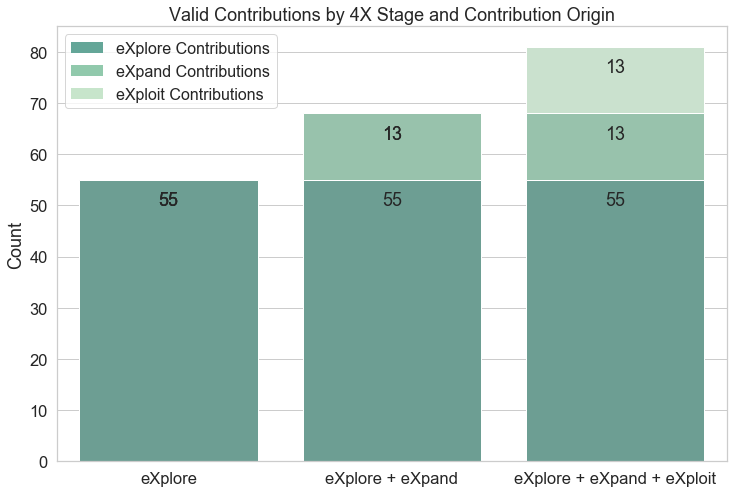

In [821]:
fig = plt.subplots(figsize=(12, 8))

# set colors
bottom_color = sns.color_palette()[0]
middle_color = sns.color_palette()[1]
top_color = sns.color_palette()[2]

# layer plots together
bottom_layer = sns.barplot(x=add_contrib_enroute['4X Stage'], y=add_contrib_enroute['Count'], color=bottom_color)
middle_layer = sns.barplot(x=add_contrib_directed['4X Stage'], y=add_contrib_directed['Count'], color=middle_color)
top_layer = sns.barplot(x=add_contrib_opportunistic['4X Stage'], y=add_contrib_opportunistic['Count'], color=top_color)

# setup legend
bottombar = plt.Rectangle((0, 0), 1, 1, fc=bottom_color, edgecolor='none')
middlebar = plt.Rectangle((0, 0), 1, 1, fc=middle_color, edgecolor='none')
topbar = plt.Rectangle((0, 0), 1, 1, fc=top_color, edgecolor='none')

l = plt.legend([topbar, middlebar, bottombar], ['eXplore Contributions', 'eXpand Contributions', 'eXploit Contributions'],
               loc=0, ncol = 1, prop={'size':16})
l.draw_frame(True)

# set axis labels
bottom_layer.set_ylim(0, 85)
bottom_layer.set_yticks(range(0, 86, 10))
bottom_layer.set_xlabel('')
bottom_layer.set_title('Valid Contributions by 4X Stage and Contribution Origin')

# add value labels to bars
for p in top_layer.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        top_layer.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        value = height
        if value > opportunistic_contributions + directed_contributions:
            value = value - opportunistic_contributions - directed_contributions
        elif value > opportunistic_contributions:
            value = value - opportunistic_contributions
            
        top_layer.text(p.get_x() + p.get_width() / 2, height - 5, '{:1.0f}'.format(value), ha="center") 

## Self-Reported Disruption

In [551]:
def create_boxplot_df(condition, df):
    """
    Creates a simple melted DF with a condition column, and a column for each attribute (value, disruption, future use, etc) to be plotted.
    
    Inputs:
        condition (string): name of condition
        df (DataFrame): current data
    
    Returns:
        (DataFrame): simplified DataFrame ready for concating and plotting
    """
    return pd.DataFrame({'condition': condition, 'value': df['overall_value'], 'disruption': df['overall_disruption'], 'future use': df['future_use']}).melt(id_vars=['condition'])

plot_melted_dfs = [
    create_boxplot_df('Opp at Location', post_study_opp_loc),
    create_boxplot_df('4X', post_study_4x),
    create_boxplot_df('Opp at Distance', post_study_opp_dist)
]
disruption_plot_data = pd.concat(plot_melted_dfs)
disruption_plot_data = disruption_plot_data[disruption_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

NameError: name 'post_study_opp_loc' is not defined

In [ ]:
fig = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=disruption_plot_data,
                 hue_order=['disruption', 'value', 'future use'])
ax.set_title('Disruption, Value, and Likeliness to Use in Future')
ax.set_xlabel('Study Conditions')
ax.set_ylabel('Value on 5-Point Likert Scale')

In [ ]:
post_study_opp_loc['overall_disruption'].describe()

In [ ]:
post_study_4x['overall_disruption'].describe()

In [ ]:
post_study_opp_dist['overall_disruption'].describe()

## Test of Significance on Disruption and Value

In [ ]:
import scipy.special as special

def FPvalue( *args):
    """ Return F an p value

    """
    df_btwn, df_within = __degree_of_freedom_( *args)

    mss_btwn = __ss_between_( *args) / float( df_btwn)   
    mss_within = __ss_within_( *args) / float( df_within)

    F = mss_btwn / mss_within    
    P = special.fdtrc( df_btwn, df_within, F)

    return( F, P)

def EffectSize( *args):
    """ Return the eta squared as the effect size for ANOVA

    """    
    return( float( __ss_between_( *args) / __ss_total_( *args)))

def __concentrate_( *args):
    """ Concentrate input list-like arrays

    """
    v = list( map( np.asarray, args))
    vec = np.hstack( np.concatenate( v))
    return( vec)

def __ss_total_( *args):
    """ Return total of sum of square

    """
    vec = __concentrate_( *args)
    ss_total = sum( (vec - np.mean( vec)) **2)
    return( ss_total)

def __ss_between_( *args):
    """ Return between-subject sum of squares

    """    
    # grand mean
    grand_mean = np.mean( __concentrate_( *args))

    ss_btwn = 0
    for a in args:
        ss_btwn += ( len(a) * ( np.mean( a) - grand_mean) **2)

    return( ss_btwn)

def __ss_within_( *args):
    """Return within-subject sum of squares

    """
    return( __ss_total_( *args) - __ss_between_( *args))

def __degree_of_freedom_( *args):
    """Return degree of freedom

       Output-
              Between-subject dof, within-subject dof
    """   
    args = list( map( np.asarray, args))
    # number of groups minus 1
    df_btwn = len( args) - 1

    # total number of samples minus number of groups
    df_within = len( __concentrate_( *args)) - df_btwn - 1

    return( df_btwn, df_within)

In [ ]:
# export data for ANOVA in R
anova_data = pd.concat([
    pd.DataFrame({'disruption': post_study_4x['overall_disruption'], 'condition': '4X'}),
    pd.DataFrame({'disruption': post_study_opp_dist['overall_disruption'], 'condition': 'Opportunistic'}),
    pd.DataFrame({'disruption': post_study_opp_loc['overall_disruption'], 'condition': 'Directed'})
])

anova_data.to_csv(path_or_buf='./analysis/anova_data.csv', index=False)

In [ ]:
F, p = stats.f_oneway(post_study_4x['overall_disruption'],
                      post_study_opp_dist['overall_disruption'],
                      post_study_opp_loc['overall_disruption'])
d = EffectSize(post_study_4x['overall_disruption'],
               post_study_opp_dist['overall_disruption'],
               post_study_opp_loc['overall_disruption'])

df_btwn, df_within = __degree_of_freedom_(post_study_4x['overall_disruption'],
                                          post_study_opp_dist['overall_disruption'],
                                          post_study_opp_loc['overall_disruption'])

anova_output_string = 'ANOVA on Disruption \nF({}, {}) = {:1.3f}, p = {:1.3f}, Cohen\'s d = {:1.3f}'
print(anova_output_string.format(df_btwn, df_within, F, p, d))

In [ ]:
F, p = stats.f_oneway(post_study_4x['overall_value'],
                      post_study_opp_dist['overall_value'],
                      post_study_opp_loc['overall_value'])
d = EffectSize(post_study_4x['overall_value'],
               post_study_opp_dist['overall_value'],
               post_study_opp_loc['overall_value'])

print('ANOVA on Value \nF: {:1.3f}, p: {:1.3f}, Cohen\'s d: {:1.3f}'.format(F, p, d))

In [ ]:
F, p = stats.f_oneway(post_study_4x['future_use'],
                      post_study_opp_dist['future_use'],
                      post_study_opp_loc['future_use'])
d = EffectSize(post_study_4x['future_use'],
               post_study_opp_dist['future_use'],
               post_study_opp_loc['future_use'])

print('ANOVA on Future Use \nF: {:1.3f}, p: {:1.3f}, Cohen\'s d: {:1.3f}'.format(F, p, d))

## Data vs. Pickup Rate vs. Disruption

In [ ]:
# task_acceptance_rate_data = pd.DataFrame({
#     'condition': [
#         '4X',
#         'Opp at Distance',
#         'Opp at Location',
#         '4X',
#         'Opp at Distance',
#         'Opp at Distance',
        
#     ],
#     'variable': [
#         'Valid Response Rate \n At Location',
#         'Valid Response Rate \n At Location',
#         'Valid Response Rate \n At Location',
#         'Task Acceptance Rate (with Info) \n 300m Away',
#         'Task Acceptance Rate (with Info) \n 300m Away',
#         'Task Acceptance Rate (without Info) \n 300m Away',
#     ],
#     'value': [
#         float(atloc_4x_count_prop_overall[atloc_4x_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
#         float(atloc_opp_dist_count_prop_overall[atloc_opp_dist_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
#         float(atloc_opp_loc_count_prop_overall[atloc_opp_loc_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
#         float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
#         float(atdist_opp_dist_info_count_prop_overall[atdist_opp_dist_info_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
#         float(atdist_opp_dist_noinfo_count_prop_overall[atdist_opp_dist_noinfo_count_prop_overall['emaResponse'] == 'Sure! I would be happy to go out of my way!']['percentage']),
#     ]
# })

atdist_taskaccepted = [
    'Yes! This info is useful, I\'m going now.',
    'Sure! I would be happy to go out of my way!'
]

task_acceptance_rate_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance',
        'Opp at Location',
        '4X',
        'Opp at Distance',
    ],
    'variable': [
        'Valid Response Rate \n At Location',
        'Valid Response Rate \n At Location',
        'Valid Response Rate \n At Location',
        'Task Acceptance Rate \n 300m Away',
        'Task Acceptance Rate \n 300m Away',
    ],
    'value': [
        float(atloc_4x_count_prop_overall[atloc_4x_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atloc_opp_dist_count_prop_overall[atloc_opp_dist_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atloc_opp_loc_count_prop_overall[atloc_opp_loc_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_all_count_prop_overall[atdist_opp_dist_all_count_prop_overall['emaResponse'].isin(atdist_taskaccepted)]['percentage'].sum())
    ]
})

task_acceptance_rate_atdist_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance',
        'Opp at Distance'
    ],
    'variable': [
        'Task Acceptance Rate (with Info) \n 300m Away',
        'Task Acceptance Rate (with Info) \n 300m Away',
        'Task Acceptance Rate (without Info) \n 300m Away',
    ],
    'value': [
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_info_count_prop_overall[atdist_opp_dist_info_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_noinfo_count_prop_overall[atdist_opp_dist_noinfo_count_prop_overall['emaResponse'] == 'Sure! I would be happy to go out of my way!']['percentage']),
    ]
})

overall_task_acceptance_rate_atdist_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance'
    ],
    'variable': [
        'Task Acceptance Rate',
        'Task Acceptance Rate'
    ],
    'value': [
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_all_count_prop_overall[atdist_opp_dist_all_count_prop_overall['emaResponse'].isin(atdist_taskaccepted)]['percentage'].sum())
    ]
})

people_notified_atdist_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance'
    ],
    'variable': [
        'Notification Count',
        'Notification Count',
    ],
    'value': [
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Total']['count']),
        float(atdist_opp_dist_all_count_prop_overall[atdist_opp_dist_all_count_prop_overall['emaResponse'] == 'Total']['count'])
    ]
})

disruption_value_data = pd.concat([
    pd.DataFrame({'condition': '4X', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_4x['overall_disruption']}),
    pd.DataFrame({'condition': 'Opp at Distance', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_opp_dist['overall_disruption']}),
    pd.DataFrame({'condition': 'Opp at Location', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_opp_loc['overall_disruption']}),
    pd.DataFrame({'condition': '4X', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_4x['overall_value']}),
    pd.DataFrame({'condition': 'Opp at Distance', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_opp_dist['overall_value']}),
    pd.DataFrame({'condition': 'Opp at Location', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_opp_loc['overall_value']})
])

In [ ]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=task_acceptance_rate_data,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Response Rate by Condition and Distance')
ax.set_xlabel('')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))
ax.set_yticklabels(['{}%'.format(x) for x in range(0, 105, 5)])

for p in ax.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.2f}%'.format(height), ha="center") 

In [ ]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=task_acceptance_rate_atdist_data,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Task Acceptance Rate At Distance With/Without Info')
ax.set_xlabel('')
ax.set_ylabel('Percentage (out of 100)')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))

for p in ax.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.2f}%'.format(height), ha="center") 

In [ ]:
people_notified_atdist_data

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='variable', y='value', hue='condition', data=people_notified_atdist_data,
            hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Notification Count At Distance With/Without Info')
ax.set_xlabel('')
ax.set_ylabel('Percentage (out of 100)')
ax.set_ylim(0, 1000)
ax.set_yticks(range(0, 1001, 50))

for p in ax.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.0f}'.format(height), ha="center") 

In [ ]:
people_notified_atdist_data

In [ ]:
fig = plt.subplots(figsize=(10, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=disruption_value_data,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Self-Reported Disruption and Value')
ax.set_xlabel('')
ax.set_ylabel('Average Rating')
ax.set_ylim(0, 5)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}'.format(height), ha="center") 

## Info vs No Info Disruption

In [ ]:
info_noinfo_plot_melted_dfs = [
    pd.DataFrame({'condition': 'Opp at Location', 'at location': post_study_opp_loc['explore_disruption']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': '4X', 'at location': post_study_4x['explore_disruption'], 'info included': post_study_4x['expand_info_disruption']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': 'Opp at Distance', 'at location': post_study_opp_dist['explore_disruption'], 'no info included': post_study_opp_dist['expand_noinfo_disruption'], 'info included': post_study_opp_dist['expand_info_disruption']}).melt(id_vars=['condition'])
]
info_disruption_plot_data = pd.concat(info_noinfo_plot_melted_dfs)
info_disruption_plot_data = info_disruption_plot_data[info_disruption_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

In [ ]:
fig = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=info_disruption_plot_data,
                 hue_order=['at location', 'info included', 'no info included'])
ax.set_title('Notification Disruptiveness by Notification Type')
ax.set_xlabel('Study Condition')
ax.set_ylabel('Value on 5-Point Likert Scale')

In [ ]:
info_noinfo_count_plot_melted_dfs = [
    pd.DataFrame({'condition': '4X', 'info included': post_study_4x['expand_info_disruption'], 'info included count': post_study_4x['expand_info_number_notif']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': 'Opp at Distance', 'no info included': post_study_opp_dist['expand_noinfo_disruption'], 'no info included count': post_study_opp_dist['expand_noinfo_number_notif'],
                  'info included': post_study_opp_dist['expand_info_disruption'], 'info included count': post_study_opp_dist['expand_info_number_notif']}).melt(id_vars=['condition'])
]
info_disruption_count_plot_data = pd.concat(info_noinfo_count_plot_melted_dfs)
info_disruption_count_plot_data = info_disruption_count_plot_data[info_disruption_count_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

In [ ]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=info_disruption_count_plot_data,
                 hue_order=['info included', 'info included count', 'no info included', 'no info included count'])
ax.set_title('Disruptiveness and Desired Count')

## Notification Rates over Time

## Daily

### 4X

In [ ]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='emaResponse',
                   data=atdist_byday_prop)

ax.set_ylabel('Percentage (out of 100)')
ax.set_xlabel('')
ax.set_title('4X: At Distance EMA Reponse Over Time')

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='remappedResponses',
                   data=atloc_byday_prop)

ax.set_ylabel('Percentage (out of 100)')
ax.set_xlabel('')
ax.set_title('4X: At Location Reponse Over Time')

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Weekly

### 4X

In [ ]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='emaResponse',
                   data=atdist_byweek_prop)
ax.set_title('4X: At Distance Task EMA Response Over Time')
ax.set_xlabel('')
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))

loc, labels = plt.xticks()
ax.set_xticklabels(labels)

for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}%'.format(height), ha="center") 

In [ ]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='remappedResponses',
                   data=atloc_byweek_prop)
ax.set_title('4X: At Location Response Over Time')
ax.set_xlabel('')
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))

loc, labels = plt.xticks()
ax.set_xticklabels(labels)

for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}%'.format(height), ha="center") 

## Scaffolding by Condition and Location

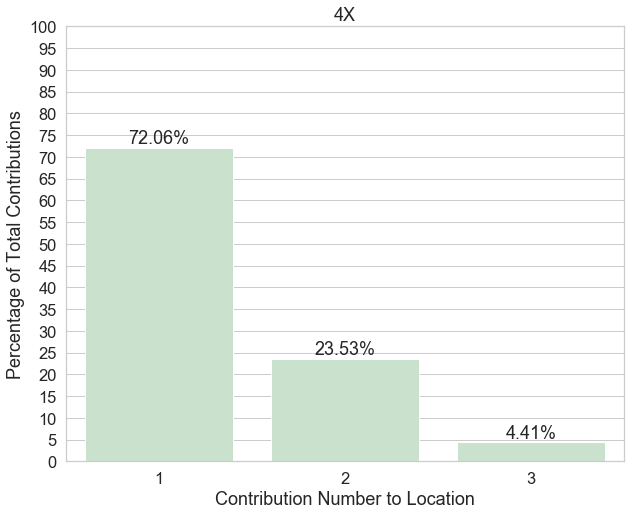

In [822]:
# histogram of locations by number of contributions
fig, ax = plt.subplots(figsize=(10, 8))

# TODO: to be more precise, any taskLocationId-reponse duplicates should be removed (user contributed same piece of knowledge that we already knew)
atloc_contrib_hist = atloc[atloc['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_contrib_hist = atloc_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_contrib_hist['total_count'] = atloc_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_contrib_hist['proportion'] = 100 * atloc_contrib_hist['total_count'] / sum(atloc_contrib_hist['total_count'])

ax = sns.barplot(data=atloc_contrib_hist,
                 x='count', y='proportion', color=sns.color_palette()[0])
ax.set(xlabel='Contribution Number to Location',
       ylabel='Percentage of Total Contributions')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))
ax.set_title('4X')

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 

In [133]:
atloc_contrib_hist

,count,instances,total_count,proportion
0,1,23,34,72.340426
1,2,9,11,23.404255
2,3,2,2,4.255319


## For You Views

In [823]:
foryou_byweek_count

,week,logString,count,condition
0,Week 1,User has viewed For You view on iOS.,86,4X
1,Week 2,User has viewed For You view on iOS.,29,4X


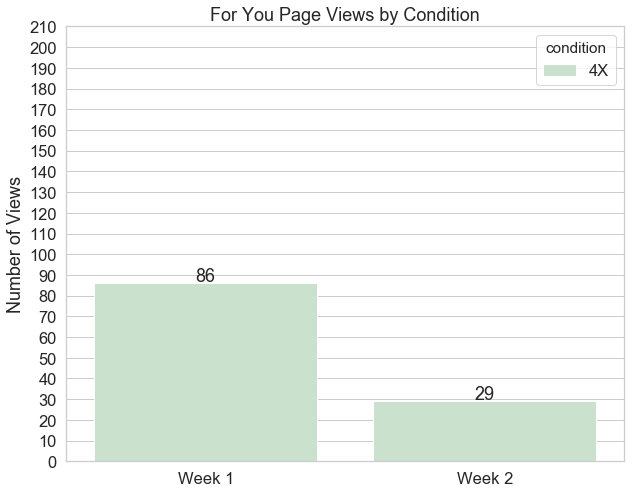

In [824]:
foryou_data = pd.concat([
    foryou_byweek_count,
])

# histogram of locations by number of contributions
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.barplot(data=foryou_data, x='week', y='count', hue='condition',
                hue_order=['4X'])
ax.set(xlabel='', ylabel='Number of Views')
ax.set_ylim(0, 210)
ax.set_yticks(range(0, 211, 10))
ax.set_title('For You Page Views by Condition')

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.0f}'.format(height), ha="center") 

# Paper Plots
This code is used to generate the final plots that will be used in the paper

## Response Rate and Disruption
Left: Response rate At Location and Task Acceptance Rate 300m from location. For 4X, 300m notifications were only sent when preferential data was available, while for Opp at Distance notifications were always sent.  We see that the task acceptance rate is lower for Opp at Distance compared to 4X, with all three conditions having roughly the same At Location response rate.

Right: Self-reported disruption and value of LES. Opp at Distance has significantly higher disruption than either Opp at Location or 4X (F: 3.935, p: 0.023, Cohen's d: 0.087). From the self-reported value, each system is shown to be approximately equally valuable. However, further analysis of the qualitative data indicates that Opp at Location users did not feel they gained much value from the application and wished that it notified them when information was available, similar to 4X.

In [ ]:
# remap variable names
graph_replacement_dict = {
    'condition': {
        'Opp at Distance': 'Directed',
        'Opp at Location': 'Opportunistic'
    }
}
task_acceptance_rate_data.replace(graph_replacement_dict, inplace=True)
disruption_value_data.replace(graph_replacement_dict, inplace=True)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(25, 8))

# create acceptance rate plot
sns.barplot(x='variable', y='value', hue='condition', data=task_acceptance_rate_data,
            hue_order=['Opportunistic', '4X', 'Directed'], ax=ax1)
ax1.set_title('Response Rate by Condition and Distance')
ax1.set_xlabel('')
ax1.set_ylabel('Percentage')
ax1.set_ylim(0, 100)
ax1.set_yticks(range(0, 101, 5))
ax1.set_yticklabels(['{}%'.format(x) for x in range(0, 105, 5)])

for p in ax1.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax1.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax1.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.2f}%'.format(height), ha="center") 
        
# create disruption plot
sns.barplot(x='variable', y='value', hue='condition', data=disruption_value_data,
            hue_order=['Opportunistic', '4X', 'Directed'], ax=ax2)
ax2.set_title('Self-Reported Disruption and Value')
ax2.set_xlabel('')
ax2.set_ylabel('Average Rating')
ax2.set_ylim(0, 5)

for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}'.format(height), ha="center") 
    
# export plot
output_fig = ax2.get_figure()
output_fig.savefig('./graphs/acceptance-disruption.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0) 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# create disruption plot
sns.barplot(x='variable', y='value', hue='condition', data=disruption_value_data,
            hue_order=['Opportunistic', '4X', 'Directed'], ax=ax)
ax.set_title('Self-Reported Disruption and Value', fontsize=24)
ax.set_xlabel('', fontsize=24)
ax.set_ylabel('Average Rating', fontsize=24)
ax.set_ylim(0, 5)
ax.tick_params(labelsize=20)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}'.format(height), ha="center", fontsize=20) 
    
# export plot
output_fig = ax.get_figure()
output_fig.savefig('./graphs/disruption.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0) 

## Data Scaffolding

In [ ]:
# histogram of locations by number of contributions
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(21, 6))
plt.subplots_adjust(top=0.85)
        
# opportunistic
atloc_opp_loc_contrib_hist = atloc_opp_loc[atloc_opp_loc['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_loc_contrib_hist = atloc_opp_loc_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_loc_contrib_hist['total_count'] = atloc_opp_loc_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_loc_contrib_hist['proportion'] = 100 * atloc_opp_loc_contrib_hist['total_count'] / sum(atloc_opp_loc_contrib_hist['total_count'])
atloc_opp_loc_contrib_hist = pd.concat([atloc_opp_loc_contrib_hist, 
                                        pd.DataFrame({'count': [5], 'instances': [0], 'total_count': [0], 'proportion': [0.0]})])

sns.barplot(data=atloc_opp_loc_contrib_hist,
            x='count', y='proportion', color=sns.color_palette()[0], ax=ax1)
ax1.set_xlabel('Contribution Number to Location', fontsize=18)
ax1.set_ylabel('Percentage of Total Contributions', fontsize=18)
ax1.set_ylim(0, 100)
ax1.set_yticks(range(0, 101, 10))
ax1.set_title('Opportunistic Condition', fontsize=20)

# Get current axis on current figure
for p in ax1.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax1.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center")
        
# 4X
atloc_4x_contrib_hist = atloc_4x[atloc_4x['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_4x_contrib_hist = atloc_4x_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_4x_contrib_hist['total_count'] = atloc_4x_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_4x_contrib_hist['proportion'] = 100 * atloc_4x_contrib_hist['total_count'] / sum(atloc_4x_contrib_hist['total_count'])
atloc_4x_contrib_hist = pd.concat([atloc_4x_contrib_hist, 
                                   pd.DataFrame({'count': [5], 'instances': [0], 'total_count': [0], 'proportion': [0.0]})])

sns.barplot(data=atloc_4x_contrib_hist,
            x='count', y='proportion', color=sns.color_palette()[1], ax=ax2)
ax2.set_xlabel('Contribution Number to Location', fontsize=18)
ax2.set_ylabel('Percentage of Total Contributions', fontsize=18)
ax2.set_ylim(0, 100)
ax2.set_yticks(range(0, 101, 10))
ax2.set_title('4X Condition', fontsize=20)

# Get current axis on current figure
for p in ax2.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax2.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 
        
# directed
atloc_opp_dist_contrib_hist = atloc_opp_dist[atloc_opp_dist['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_dist_contrib_hist = atloc_opp_dist_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_dist_contrib_hist['total_count'] = atloc_opp_dist_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_dist_contrib_hist['proportion'] = 100 * atloc_opp_dist_contrib_hist['total_count'] / sum(atloc_opp_dist_contrib_hist['total_count'])
atloc_opp_dist_contrib_hist = pd.concat([atloc_opp_dist_contrib_hist, 
                                         pd.DataFrame({'count': [5], 'instances': [0], 'total_count': [0], 'proportion': [0.0]})])

sns.barplot(data=atloc_opp_dist_contrib_hist,
            x='count', y='proportion', color=sns.color_palette()[2], ax=ax3)
ax3.set_xlabel('Contribution Number to Location', fontsize=18)
ax3.set_ylabel('Percentage of Total Contributions', fontsize=18)
ax3.set_ylim(0, 100)
ax3.set_yticks(range(0, 101, 10))
ax3.set_title('Directed Condition', fontsize=20)

# Get current axis on current figure
for p in ax3.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax3.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 
        
# export plot
fig.suptitle('Percentage of Total Contributions by Increasing Level of Fidelity', fontsize=24)
output_fig = ax3.get_figure()
output_fig.savefig('./graphs/data-scaffolding.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0) 

In [ ]:
# combined scaffolding data
combined_scaffolding_graph = pd.concat([atloc_opp_loc_contrib_hist, atloc_4x_contrib_hist, atloc_opp_dist_contrib_hist])[['count', 'total_count']]
combined_scaffolding_graph = combined_scaffolding_graph.groupby('count')['total_count'].sum().reset_index()
combined_scaffolding_graph['proportion'] = 100 * combined_scaffolding_graph['total_count'] / sum(combined_scaffolding_graph['total_count'])
combined_scaffolding_graph

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data=combined_scaffolding_graph, color=sns.color_palette()[3],
            x='count', y='proportion', ax=ax)
ax.set_xlabel('Contribution Number to Location', fontsize=24)
ax.set_ylabel('Percentage of Total Contributions', fontsize=24)

ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.set_title('Data Scaffolding Across All Conditions', fontsize=24)
ax.tick_params(labelsize=20)

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center", fontsize=20) 
        
output_fig = ax.get_figure()
output_fig.savefig('./graphs/data-scaffolding-all.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0) 

In [ ]:
# opportunistic
atloc_opp_loc_contrib_hist = atloc_opp_loc[atloc_opp_loc['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_loc_contrib_hist = atloc_opp_loc_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_loc_contrib_hist['total_count'] = atloc_opp_loc_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_loc_contrib_hist['proportion'] = 100 * atloc_opp_loc_contrib_hist['total_count'] / sum(atloc_opp_loc_contrib_hist['total_count'])
atloc_opp_loc_contrib_hist['condition'] = 'Opportunistic'

# 4X
atloc_4x_contrib_hist = atloc_4x[atloc_4x['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_4x_contrib_hist = atloc_4x_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_4x_contrib_hist['total_count'] = atloc_4x_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_4x_contrib_hist['proportion'] = 100 * atloc_4x_contrib_hist['total_count'] / sum(atloc_4x_contrib_hist['total_count'])
atloc_4x_contrib_hist['condition'] = '4X'

# directed
atloc_opp_dist_contrib_hist = atloc_opp_dist[atloc_opp_dist['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_dist_contrib_hist = atloc_opp_dist_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_dist_contrib_hist['total_count'] = atloc_opp_dist_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_dist_contrib_hist['proportion'] = 100 * atloc_opp_dist_contrib_hist['total_count'] / sum(atloc_opp_dist_contrib_hist['total_count'])
atloc_opp_dist_contrib_hist['condition'] = 'Directed'

# combined plot data 
contribution_hist_data = pd.concat([atloc_opp_loc_contrib_hist, atloc_4x_contrib_hist, atloc_opp_dist_contrib_hist])

In [ ]:
fig, ax = plt.subplots(figsize=(30, 8))

sns.barplot(data=contribution_hist_data,
            x='count', y='proportion', hue='condition', ax=ax)
ax.set(xlabel='Contribution Number to Location',
       ylabel='Percentage of Total Contributions')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))
ax.set_title('Directed')

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 